In [5]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); sys.path.append('..')
import lib.tools.Toolbox as tb
import lib.tools.TimeKeeper as tk
import metadata.trade_configs.Globals as gb
import lib.tools.Broker as br
import lib.tools.Scrivener as sc
import lib.tools.Logger as log
import glob
import pandas as pd
import alpaca_trade_api as alp
from lib.tools.Config import Config
from lib.Portfolio import Portfolio
from lib.RoboTrader import RoboTrader
from lib.strategies.MomentumSeeking import MomentumSeeking
from lib.strategies.ParabolaSeeking import ParabolaSeeking
import lib.tools.Tuner as tuner
import matplotlib.pyplot as plt
%matplotlib widget

api = br.paper_api()
bars = api.get_bars('NVDA', alp.TimeFrame.Day, start=tk.dto_time(tk.d(1,1,year=2022)), end=tk.dto_time(tk.d(6,20))).df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Activating with Paper


# Something to Investigate
Is there a correlation between large jumps in the yesterday closing price and today open price and a general profitability? We can test this on NVDA and then move out to different stocks. Steps are clear:
1. Develop function to determine "large" jump in price difference
2. Apply that function to day data to select a number of dates
3. Verify date selection
4. Run tuner on each of these days and collect the results
5. Compare results with control run on same period and get a percentage difference

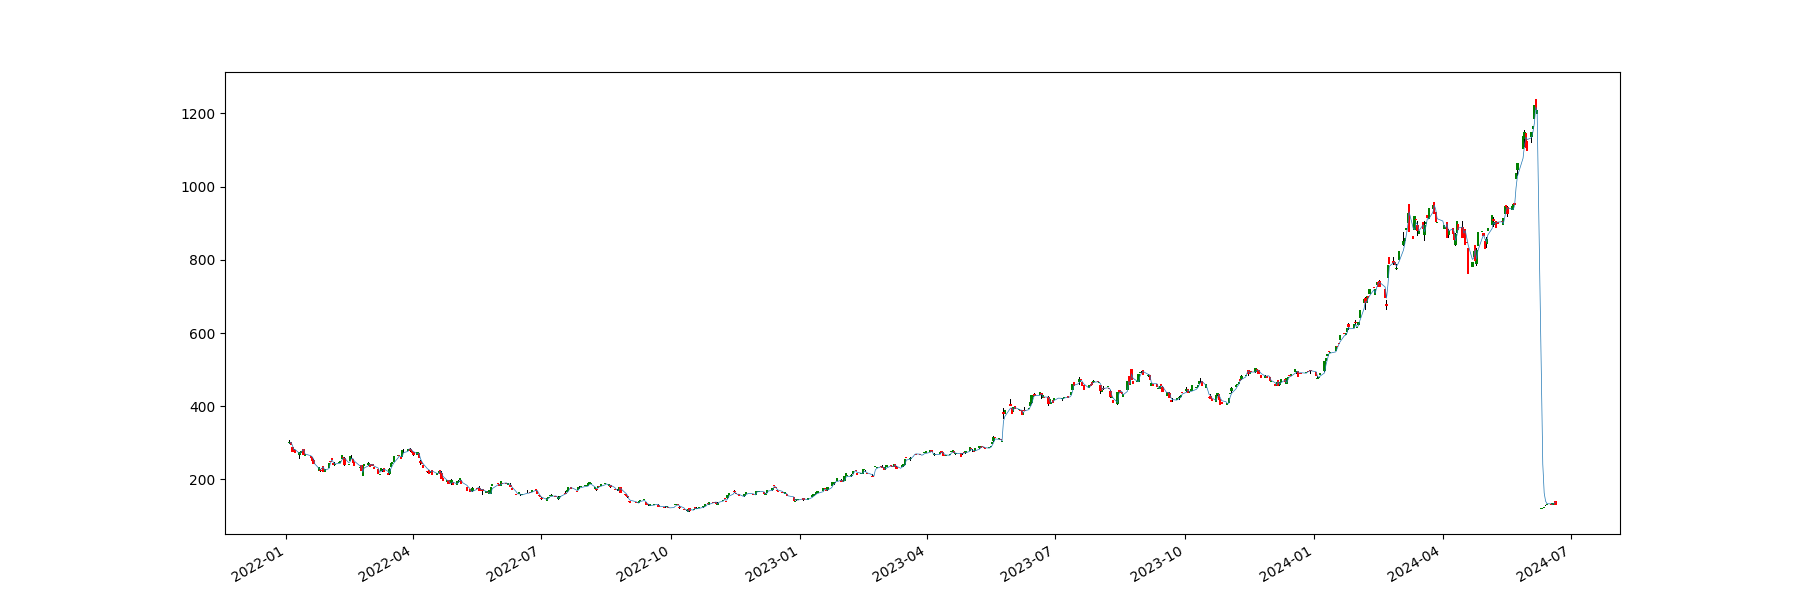

In [8]:
tb.candle_plot(bars, .0005, .0005, show=True)

Dates Covered
 [Timestamp('2024-01-10 05:00:00+0000', tz='UTC'), Timestamp('2024-01-11 05:00:00+0000', tz='UTC'), Timestamp('2024-01-18 05:00:00+0000', tz='UTC'), Timestamp('2024-01-19 05:00:00+0000', tz='UTC'), Timestamp('2024-01-25 05:00:00+0000', tz='UTC'), Timestamp('2024-01-26 05:00:00+0000', tz='UTC'), Timestamp('2024-01-31 05:00:00+0000', tz='UTC'), Timestamp('2024-02-02 05:00:00+0000', tz='UTC'), Timestamp('2024-02-05 05:00:00+0000', tz='UTC'), Timestamp('2024-02-12 05:00:00+0000', tz='UTC'), Timestamp('2024-02-13 05:00:00+0000', tz='UTC'), Timestamp('2024-02-16 05:00:00+0000', tz='UTC'), Timestamp('2024-02-21 05:00:00+0000', tz='UTC'), Timestamp('2024-02-22 05:00:00+0000', tz='UTC'), Timestamp('2024-02-29 05:00:00+0000', tz='UTC'), Timestamp('2024-03-04 05:00:00+0000', tz='UTC'), Timestamp('2024-03-06 05:00:00+0000', tz='UTC'), Timestamp('2024-03-07 05:00:00+0000', tz='UTC'), Timestamp('2024-03-08 05:00:00+0000', tz='UTC'), Timestamp('2024-03-11 04:00:00+0000', tz='UTC'), Time

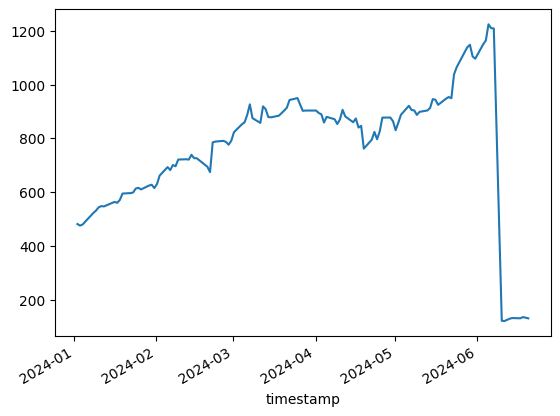

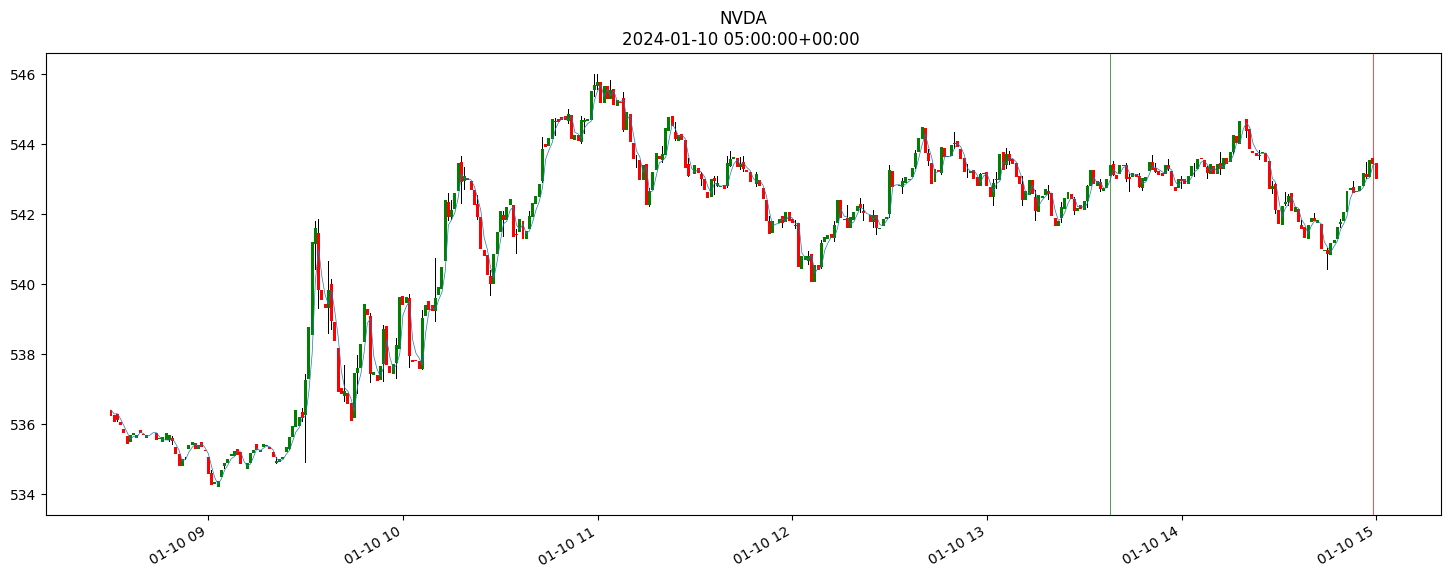

1/10 Wednesday -142.4 		 0
1/11 Thursday 0 		 -142.4


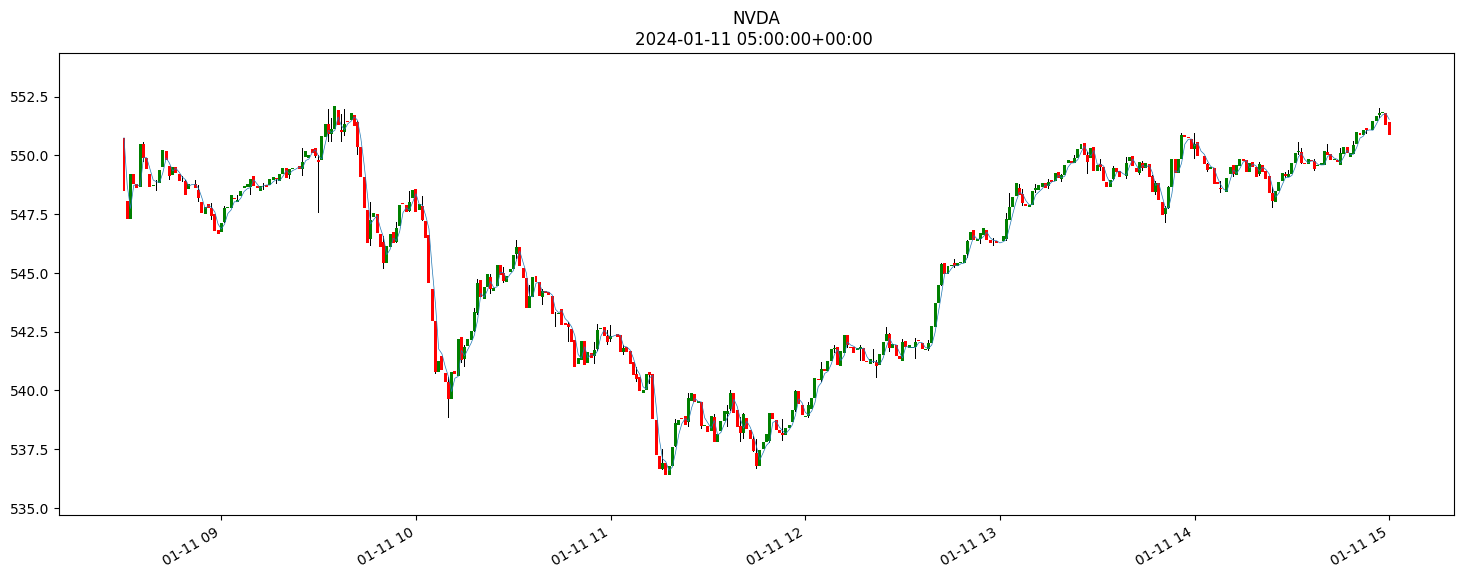

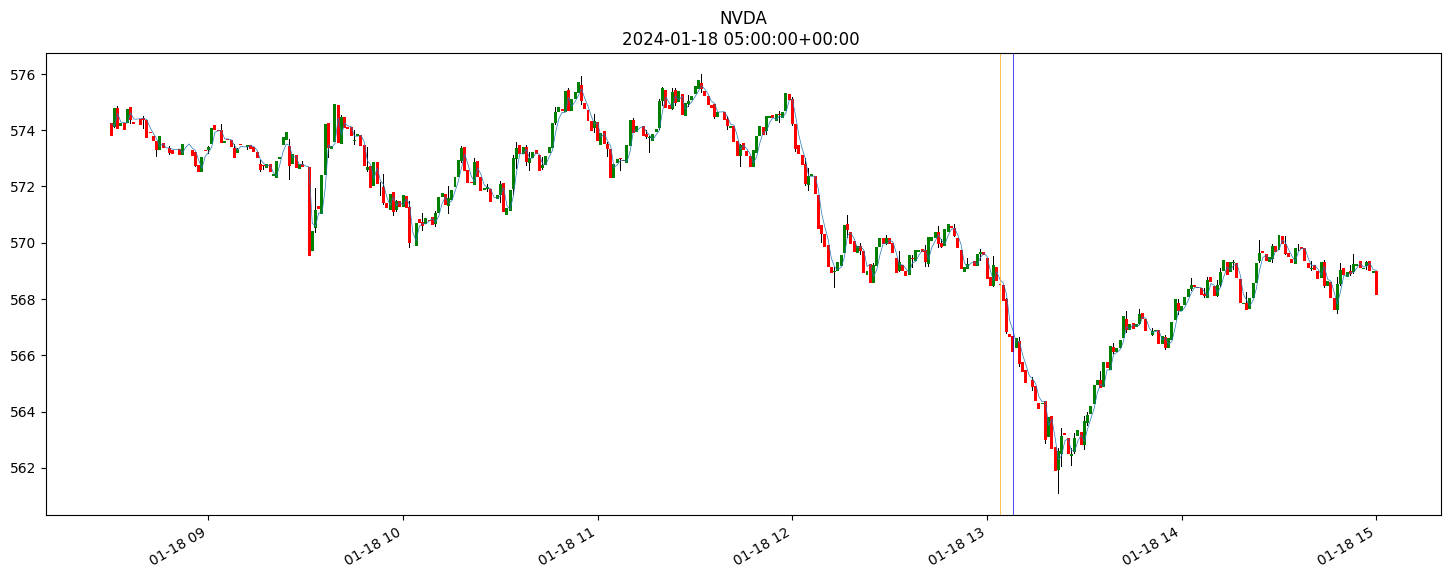

1/18 Thursday 248.43 		 -142.4
1/19 Friday 0 		 106.03


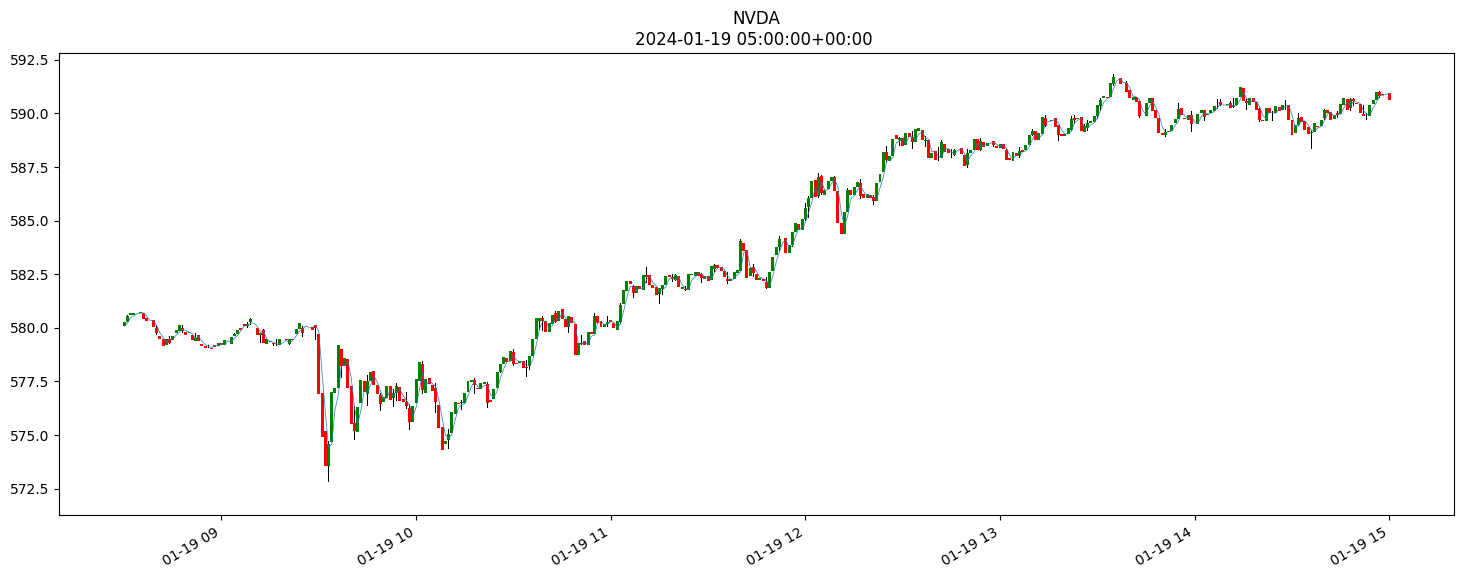

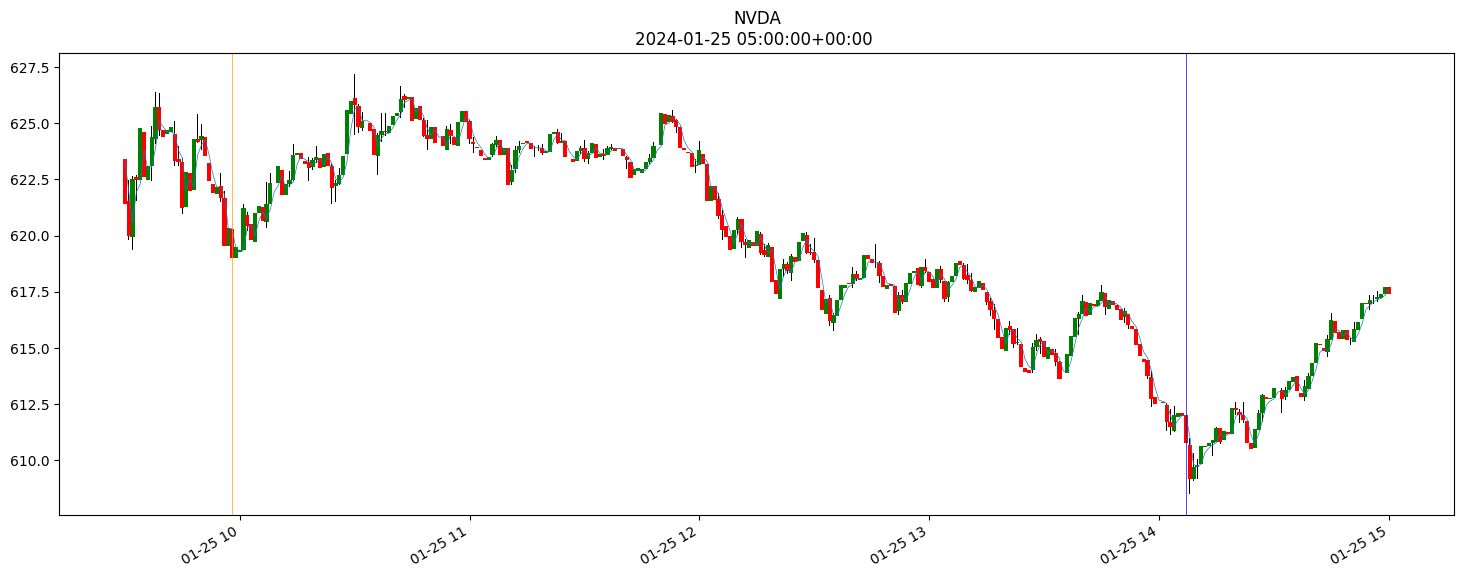

1/25 Thursday 754.85 		 106.03


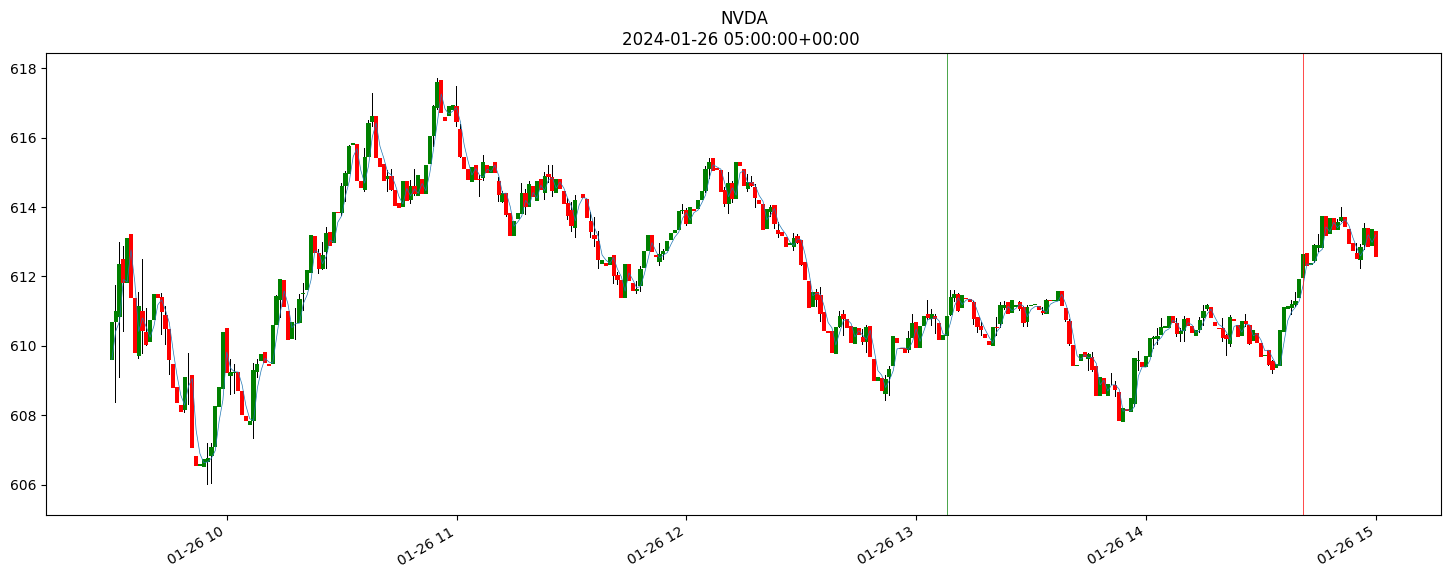

1/26 Friday -887.05 		 860.88


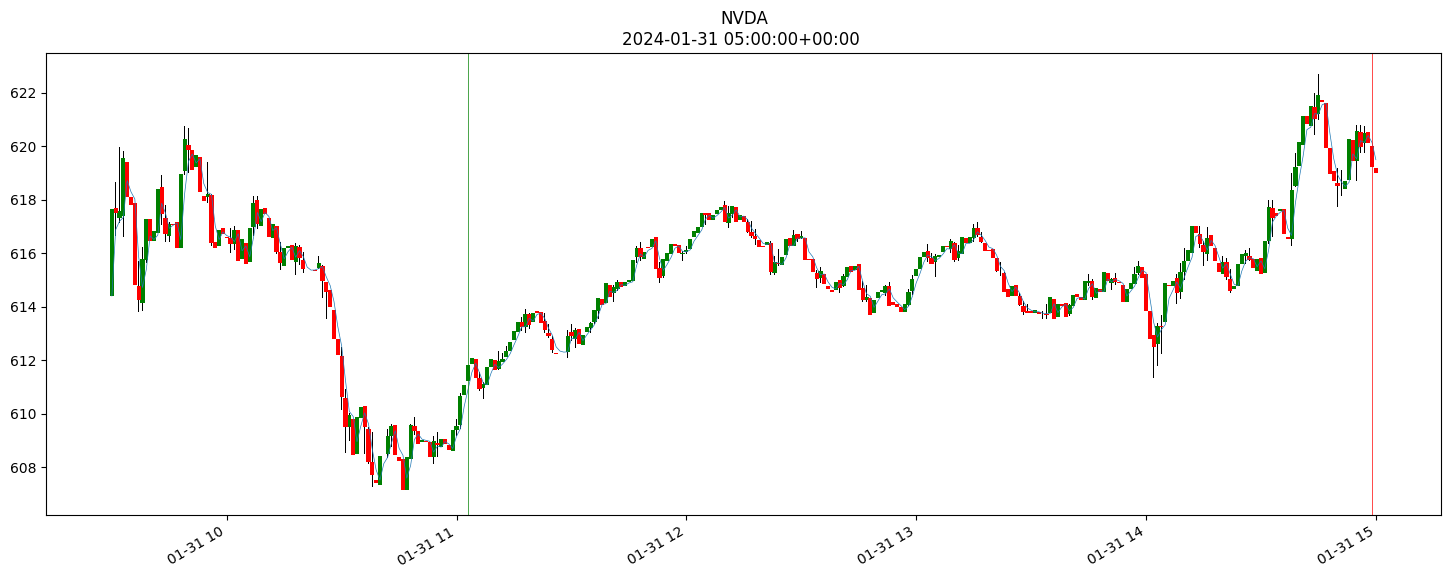

1/31 Wednesday -94.2 		 -26.17


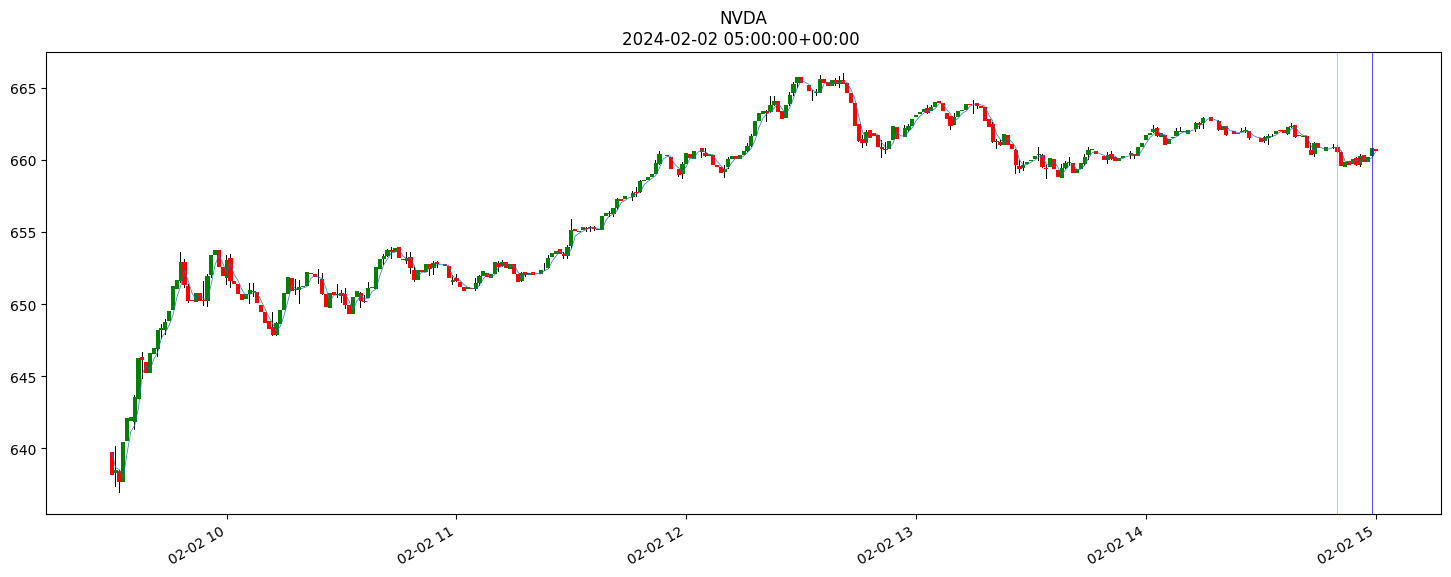

2/2 Friday -140.16 		 -120.37


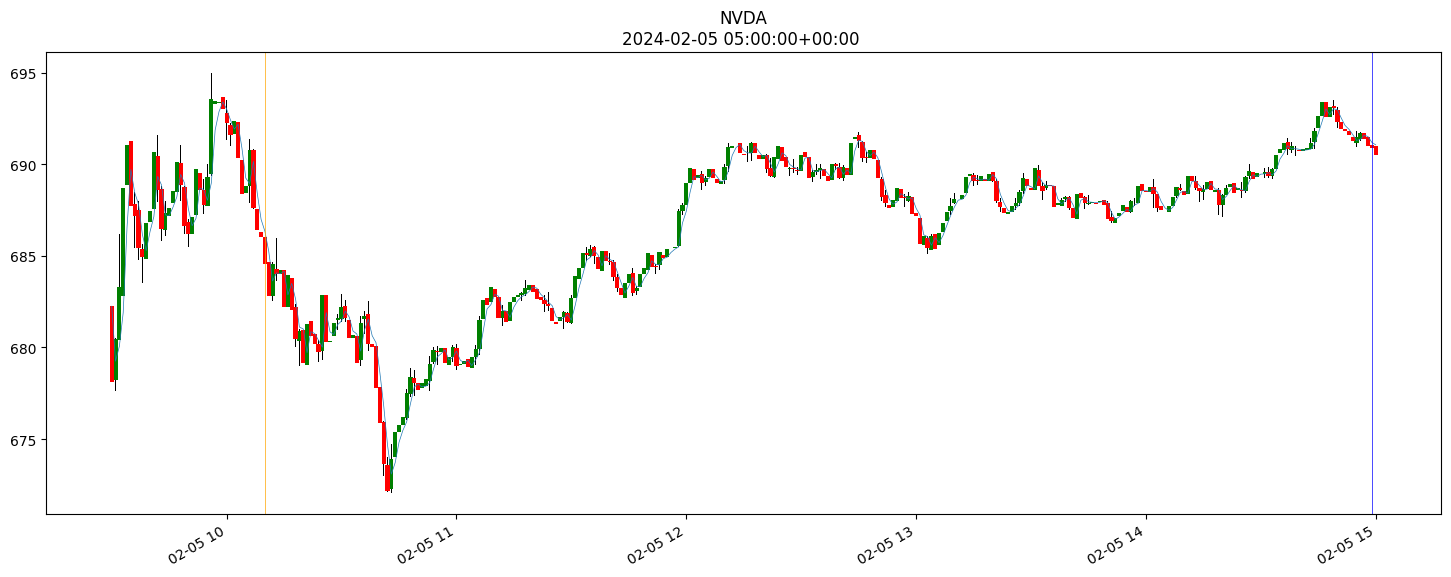

2/5 Monday -978.54 		 -260.53


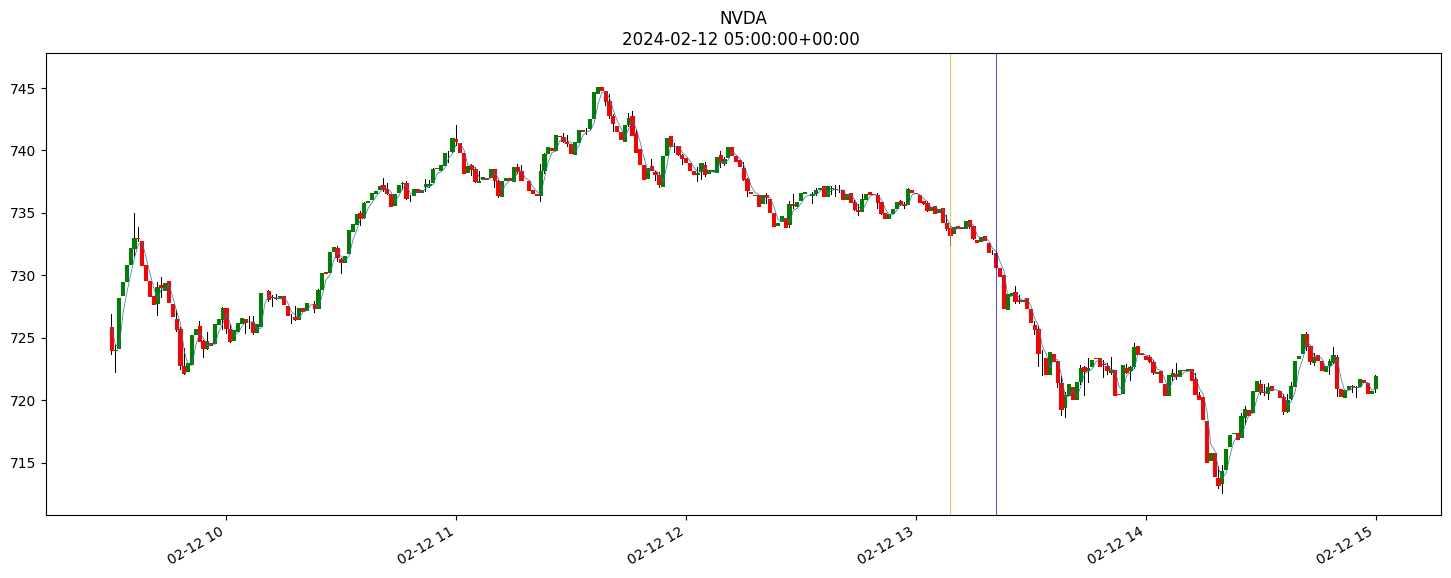

2/12 Monday 334.1 		 -1239.07
2/13 Tuesday 0 		 -904.97


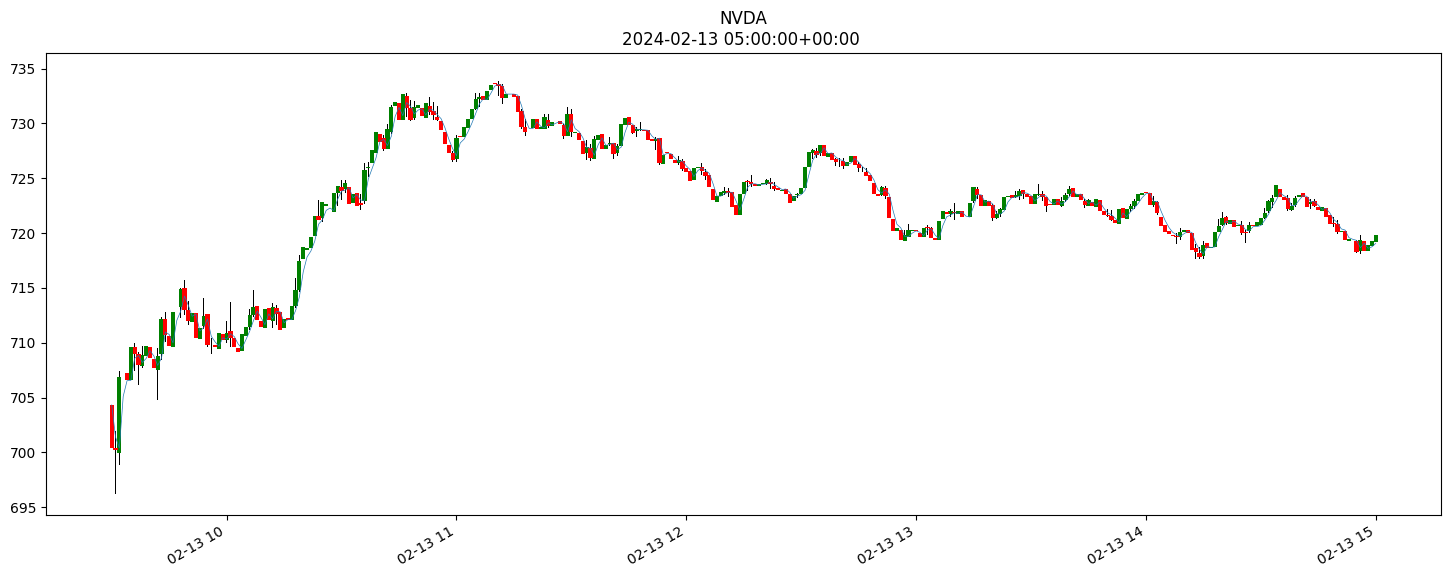

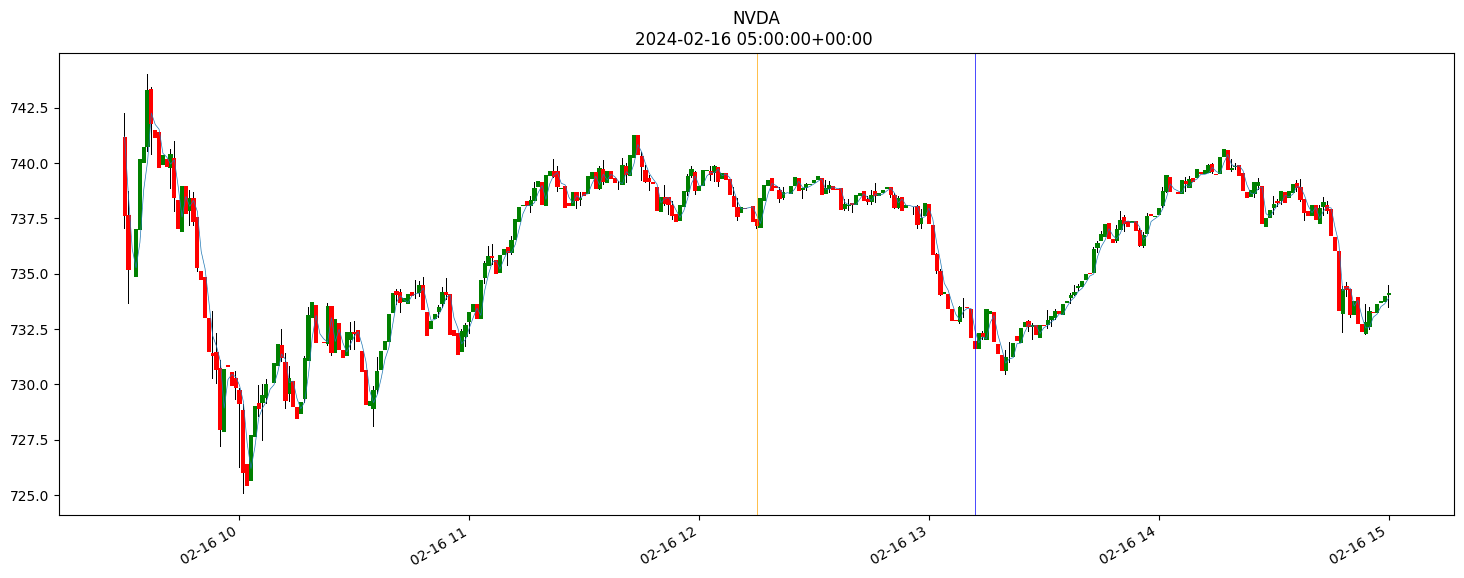

2/16 Friday 15.6 		 -904.97


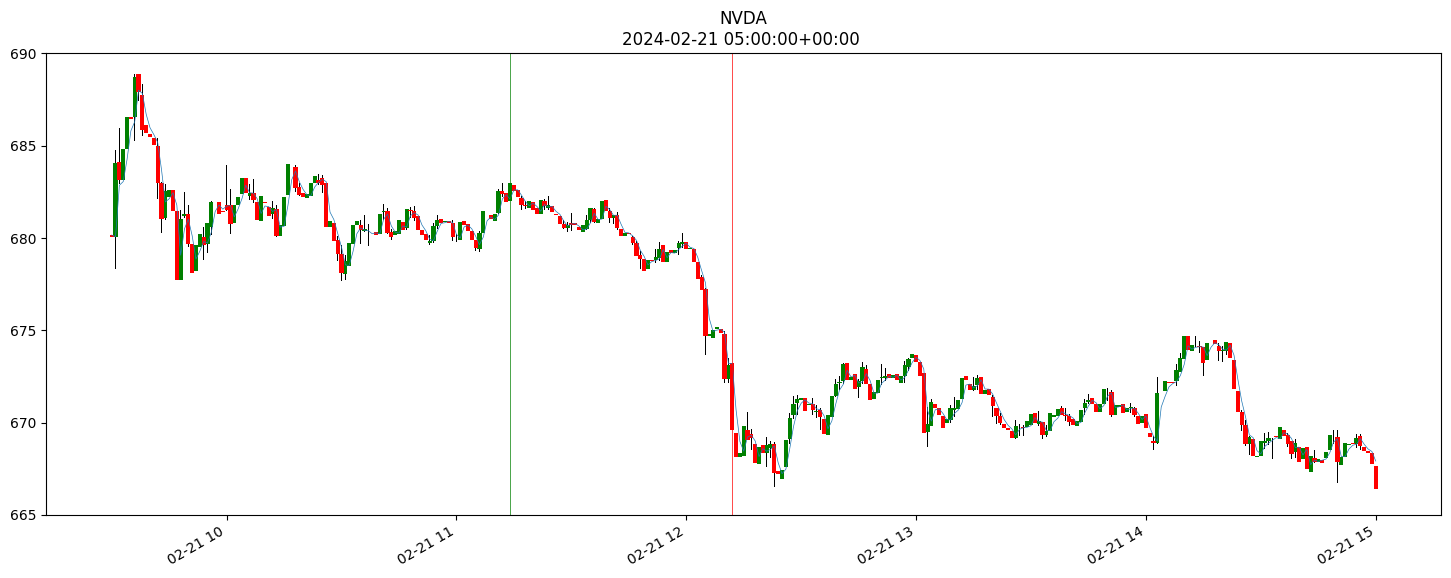

2/21 Wednesday 252.39 		 -889.37


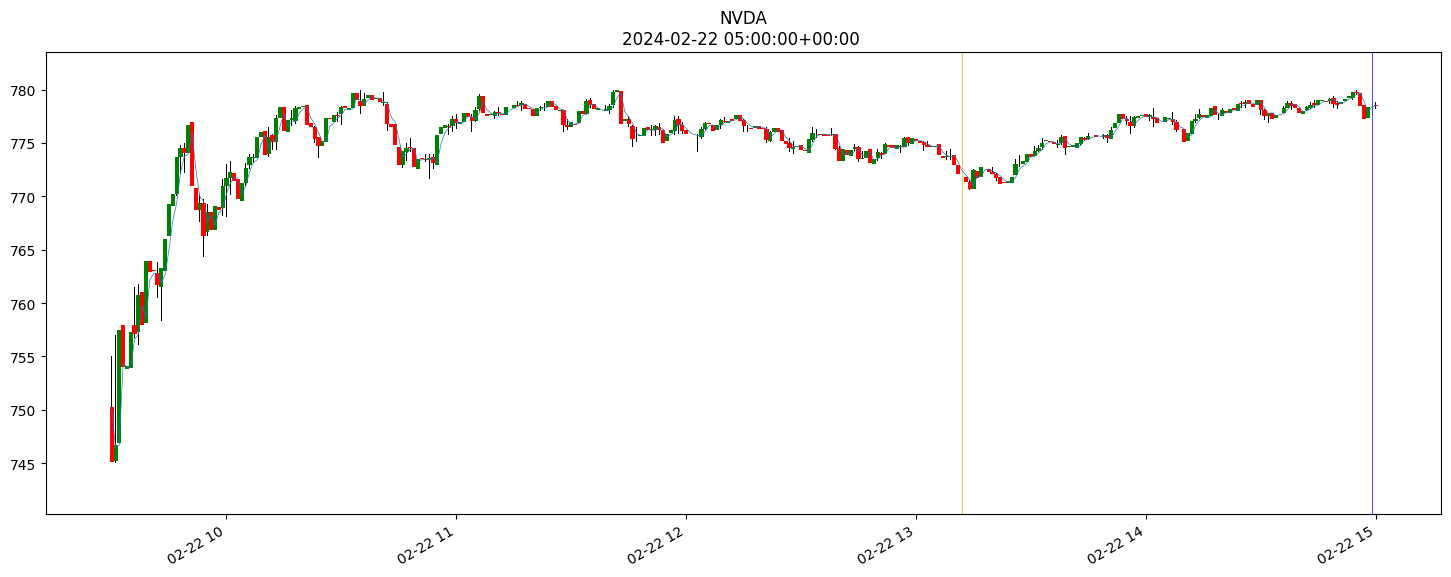

2/22 Thursday -66.42 		 -636.98


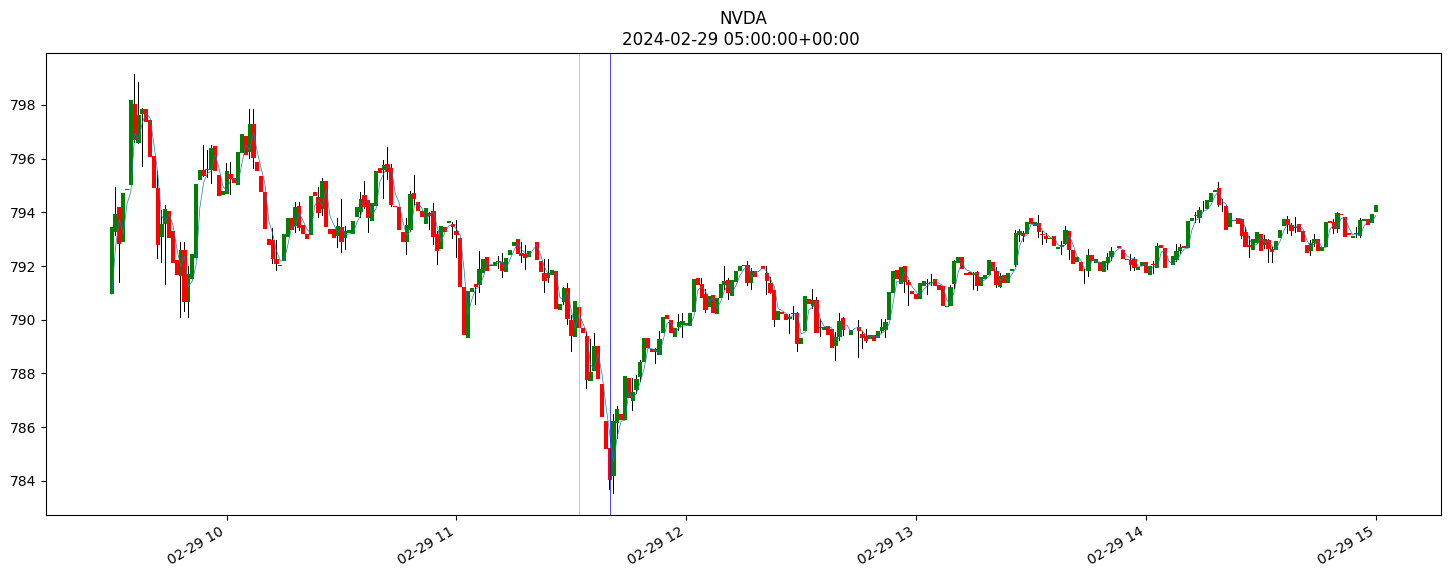

2/29 Thursday -284.35 		 -703.4


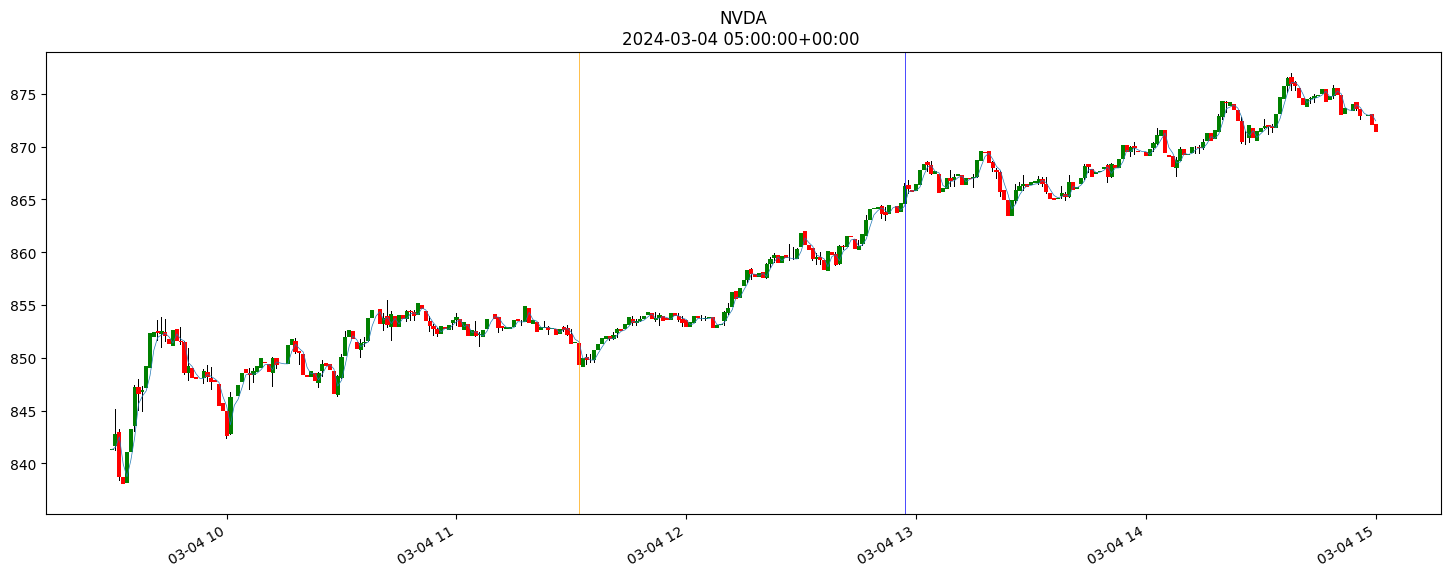

3/4 Monday -169.12 		 -987.75


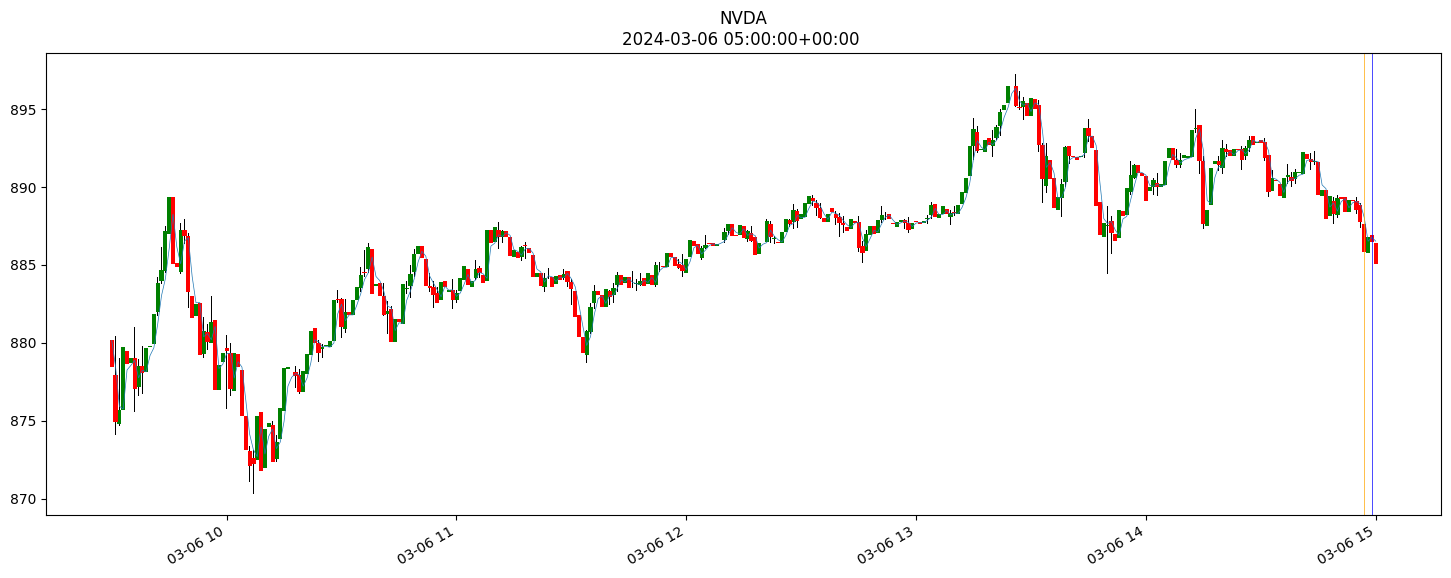

3/6 Wednesday 145.52 		 -1156.87


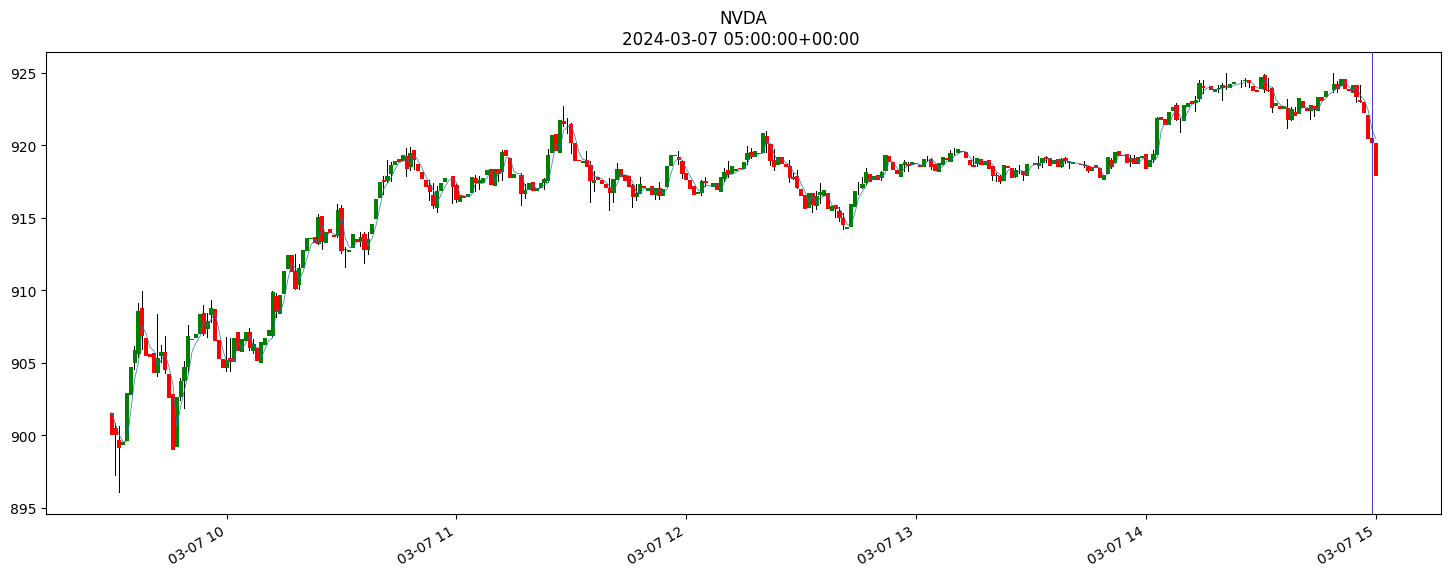

3/7 Thursday -10.3 		 -1011.35


KeyboardInterrupt: 

In [9]:
# Get day data
symbol = 'NVDA'
bars = bars[['open','close']]
bars.close.plot.line()
dates_to_test = []
profit_total = 0
count = 0
for i in range(len(bars))[5:-1]:
    lookback_span = bars.iloc[i-5:i]
    opclo = lookback_span.close - lookback_span.open.shift(-1)
    expected_change = opclo.std()

    day_of_investigation, previous_day = bars.iloc[i], bars.iloc[i-1]
    if abs(previous_day.close - day_of_investigation.open) > expected_change:
        dates_to_test.append(bars.index[i])
        count+=1

results = tuner.tuning(symbol, dates_to_test, show=True, allow_output=True)
print(count/len(bars))
print(profit_total/count)

In [37]:
# CONTROL
profit_total = 0
count = 0
for i in range(len(bars))[5:-1]:
    print(bars.index[i])
    results = tuner.tuning(symbol, bars.index[i],allow_output=False)
    profit_total += results.profit.iloc[0]
    count+=1
print(profit_total/count)

2024-01-09 05:00:00+00:00
2024-01-10 05:00:00+00:00
2024-01-11 05:00:00+00:00
2024-01-12 05:00:00+00:00
2024-01-16 05:00:00+00:00
2024-01-17 05:00:00+00:00
2024-01-18 05:00:00+00:00
2024-01-19 05:00:00+00:00
2024-01-22 05:00:00+00:00
2024-01-23 05:00:00+00:00
2024-01-24 05:00:00+00:00
2024-01-25 05:00:00+00:00
2024-01-26 05:00:00+00:00
2024-01-29 05:00:00+00:00
2024-01-30 05:00:00+00:00
2024-01-31 05:00:00+00:00
2024-02-01 05:00:00+00:00
2024-02-02 05:00:00+00:00
2024-02-05 05:00:00+00:00
2024-02-06 05:00:00+00:00
2024-02-07 05:00:00+00:00
2024-02-08 05:00:00+00:00
2024-02-09 05:00:00+00:00
2024-02-12 05:00:00+00:00
2024-02-13 05:00:00+00:00
2024-02-14 05:00:00+00:00
2024-02-15 05:00:00+00:00
2024-02-16 05:00:00+00:00
2024-02-20 05:00:00+00:00
2024-02-21 05:00:00+00:00
2024-02-22 05:00:00+00:00
2024-02-23 05:00:00+00:00
2024-02-26 05:00:00+00:00
2024-02-27 05:00:00+00:00
2024-02-28 05:00:00+00:00
2024-02-29 05:00:00+00:00
2024-03-01 05:00:00+00:00
2024-03-04 05:00:00+00:00
2024-03-05 0

ENTER LONG STARTING 2023-03-15 04:00:00+00:00
ENTER LONG STARTING 2023-05-10 04:00:00+00:00
ENTER LONG STARTING 2023-07-17 04:00:00+00:00
ENTER SHORT STARTING 2023-08-11 04:00:00+00:00
ENTER LONG STARTING 2023-08-30 04:00:00+00:00
ENTER SHORT STARTING 2023-09-20 04:00:00+00:00
ENTER LONG STARTING 2023-12-27 05:00:00+00:00
ENTER SHORT STARTING 2024-04-19 04:00:00+00:00
ENTER LONG STARTING 2024-05-08 04:00:00+00:00


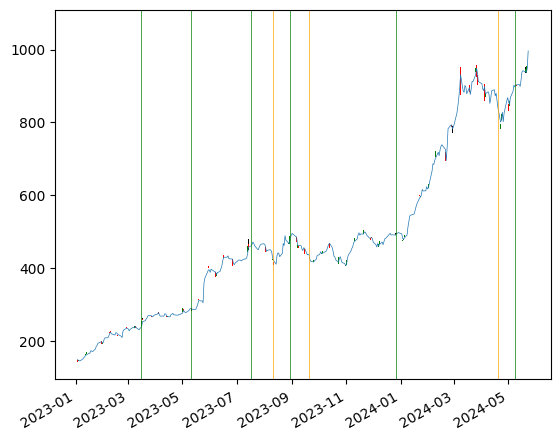

In [2]:
BOL_DEV, KC_MULT, KC_WINDOW, SQUEEZE_DURATION = 2, 2, 20, 4
bollinger = tb.get_bollinger_bands(bars.close, KC_WINDOW, num_stds=(BOL_DEV,0,-BOL_DEV))
keltner = tb.get_keltner_bands(bars, KC_WINDOW, KC_MULT)
squeeze = tb.get_squeeze_momentum(bars, keltner, bollinger, KC_WINDOW, min_squeeze=SQUEEZE_DURATION, offset=False)

tb.candle_plot(bars, .005, .005)
for index in squeeze.index:
    entry = squeeze.loc[index]
    if entry.enter_long: plt.axvline(index, lw=.5, color='green'); print('ENTER LONG STARTING', index)
    elif entry.enter_short: plt.axvline(index, lw=.5, color='orange'); print('ENTER SHORT STARTING', index)
plt.show()

In [3]:
# ATR TESTING
atr = tb.get_atr(bars)
for i in range(len(atr.index))[14:]:
    print(i, atr.iloc[i], atr.iloc[i] - abs(bars.iloc[i].close - bars.iloc[i].open))

14 8.439242896316651 4.059242896316656
15 8.381837796611126 4.276837796611137
16 8.43307499554545 7.423074995545431
17 8.811700135601127 -0.21829986439887428
18 9.135433176312057 1.2554331763120619
19 8.968494310053115 5.293494310053104
20 9.669191433771841 -2.850808566228169
21 9.924535388927033 2.83453538892703
22 9.89214643101851 8.89214643101851
23 9.712980248564955 6.882980248564971
24 9.883748942556283 1.973748942556286
25 9.783461972267538 7.963461972267545
26 9.717962933372547 7.0279629333725495
27 10.175716220814381 5.925716220814381
28 10.231611479670756 7.731611479670756
29 10.764963102750485 -3.1650368972495215
30 10.595554493632878 8.445554493632901
31 10.418978879011359 9.108978879011357
32 10.407241949131791 7.977241949131784
33 10.278259062496144 6.828259062496155
34 10.010395561068844 9.540395561068845
35 11.657001221857495 9.417001221857515
36 11.312600144008739 10.702600144008725
37 10.902363824543828 9.21236382454383
38 10.544342908113551 8.984342908113549
39 10.312

32.97020815372539 943.69 924.79 947.4 918.06


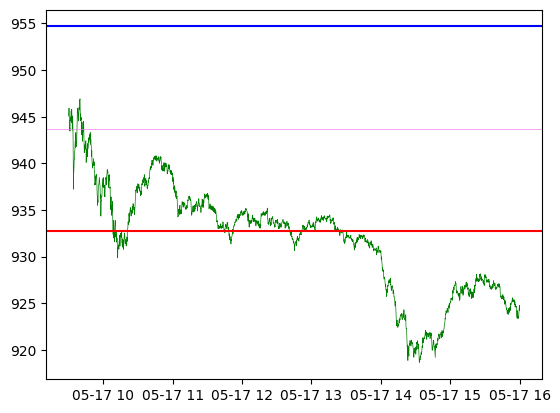

32.558764714170565 937.5 947.8 952.0 934.4


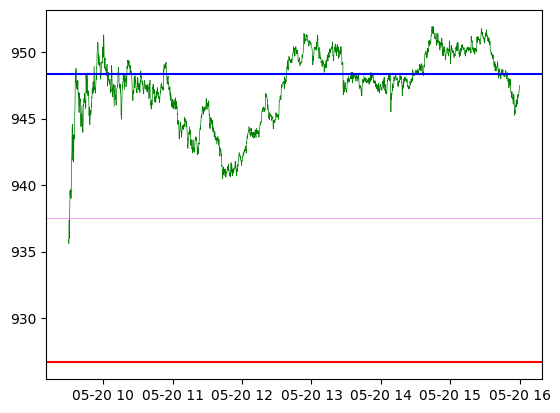

31.818852948867647 935.99 953.86 954.0 931.8


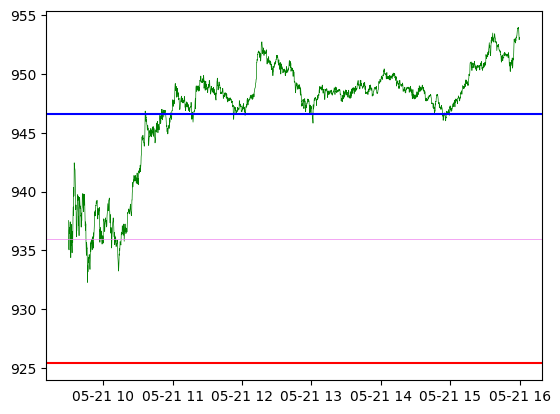

31.525363452518107 954.59 949.5 960.2 932.49


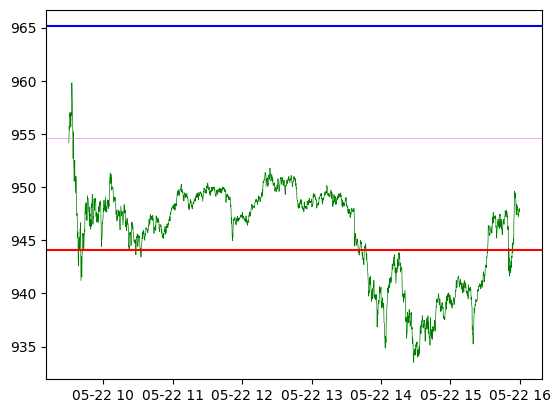

37.394980348801184 1020.28 1037.99 1063.2 1015.2


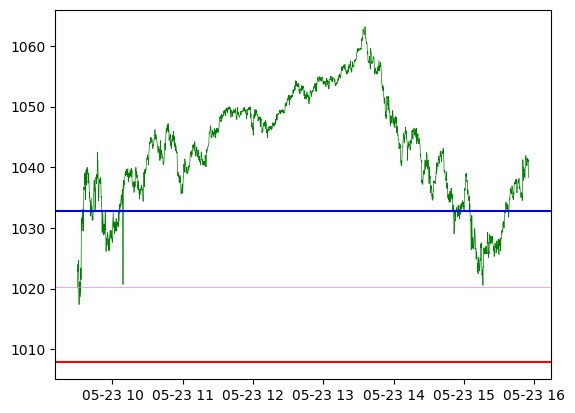

In [6]:
plt.close()
for index in atr.index[-5:]:
    i = tb.get_i(index, atr)
    a = atr.iloc[i]
    bar = bars.iloc[i]
    print(a, bar.open, bar.close, bar.high, bar.low)
    #sc.update_archive('NVDA', tk.d(5,23))
    arch = sc.get_archive('NVDA', index)
    tb.qp(arch.close, 'green')
    plt.axhline(bar.open, color='violet', lw=.5)
    plt.axhline(bar.open-a/3, color='red')
    plt.axhline(bar.open+a/3, color='blue')
    plt.show()

# Mass Scale Squeeze Momentum Viability Testing
How is this going to work? What is the nature of our experiment. We are going to look at the amount that all squeeze momentum signals fluctuate by following their entry, which is to say, how much is the average amount of maximum or minimum in the window created by the squeeze momentum before the exit point of either another squeeze momentum entry, or the value switching to negative.

In [14]:
for f in glob.glob('../logs/training/*/*_ORDERS.tsv'):
    df = pd.read_csv(f, delimiter='\t')
    for index in df.index:
        e = df.loc[index]
        if e.profit < 0 and e.note == 'NORM':
            print(e)
            print('\n')
        

index            15:43:40
type                limit
side                 SELL
filled_price    948.19855
qty                    80
profit            -1.3424
note                 NORM
atr              0.458692
Name: 27, dtype: object


index             12:11:20
type                 limit
side              SHORTBUY
filled_price    908.390397
qty                    -85
profit         -110.887883
note                  NORM
atr               0.647694
Name: 13, dtype: object


index            14:47:50
type                limit
side             SHORTBUY
filled_price    914.96533
qty                   -84
profit           -2.08152
note                 NORM
atr              0.383221
Name: 31, dtype: object


index              13:35:40
type                  limit
side                   SELL
filled_price    1062.528667
qty                      69
profit             -4.18807
note                   NORM
atr                1.072568
Name: 13, dtype: object


index            14:15:30
type          

# Searching for Large Discrepencies

['2024', '04', '11']
['2024', '04', '25']


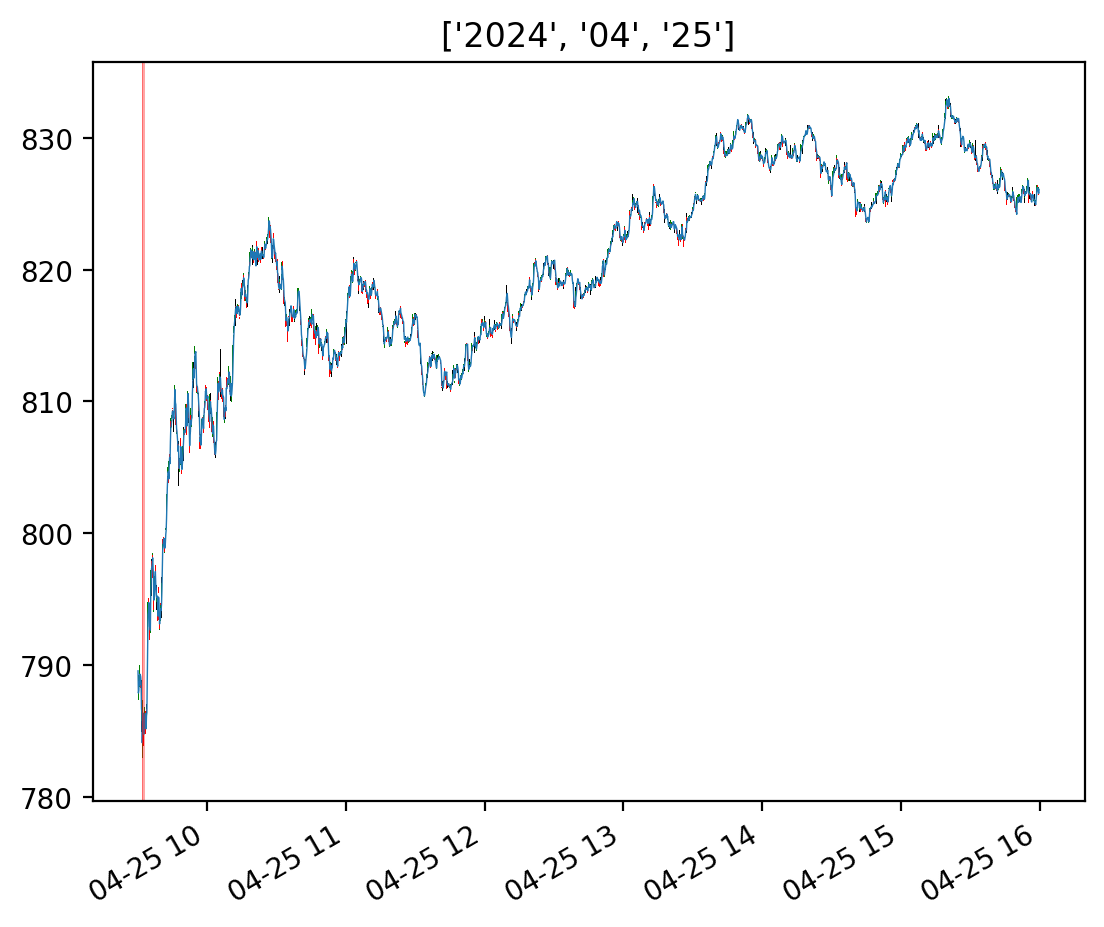

['2024', '04', '16']


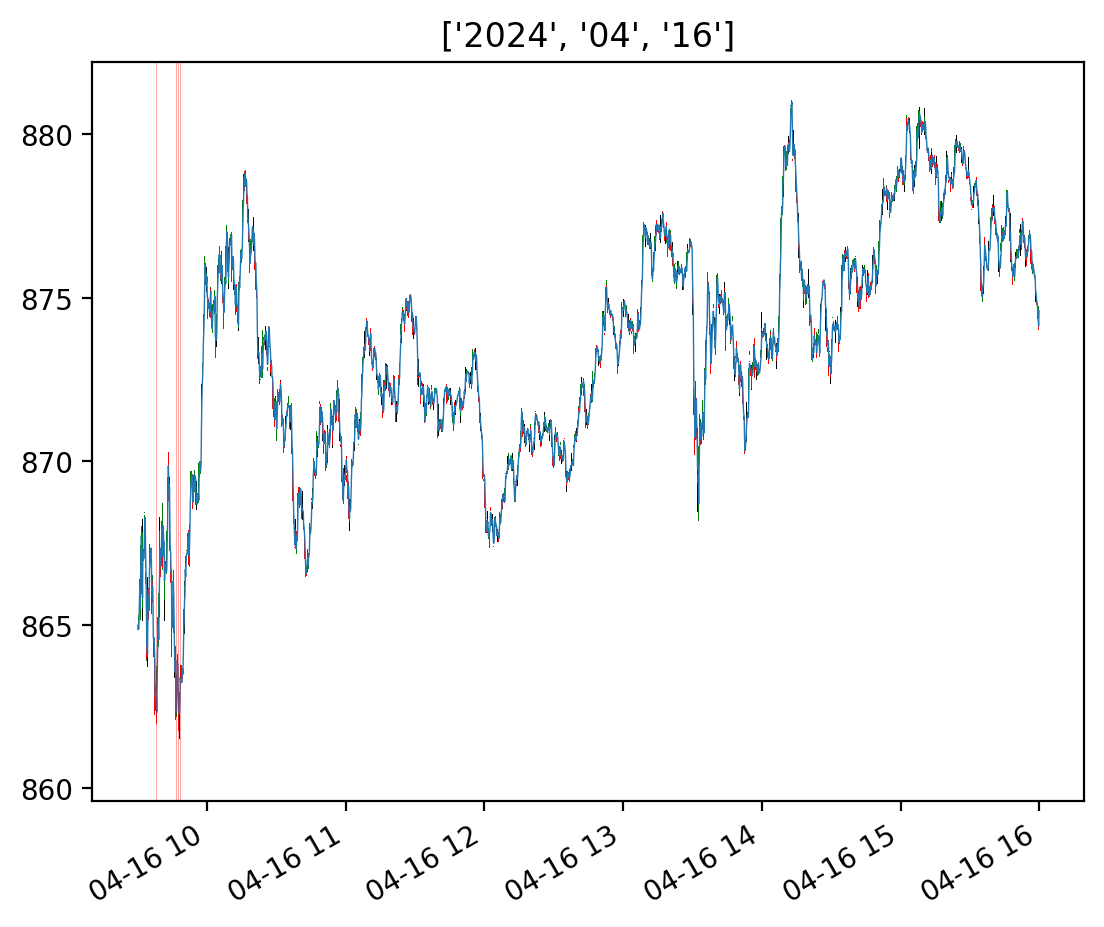

['2024', '04', '19']


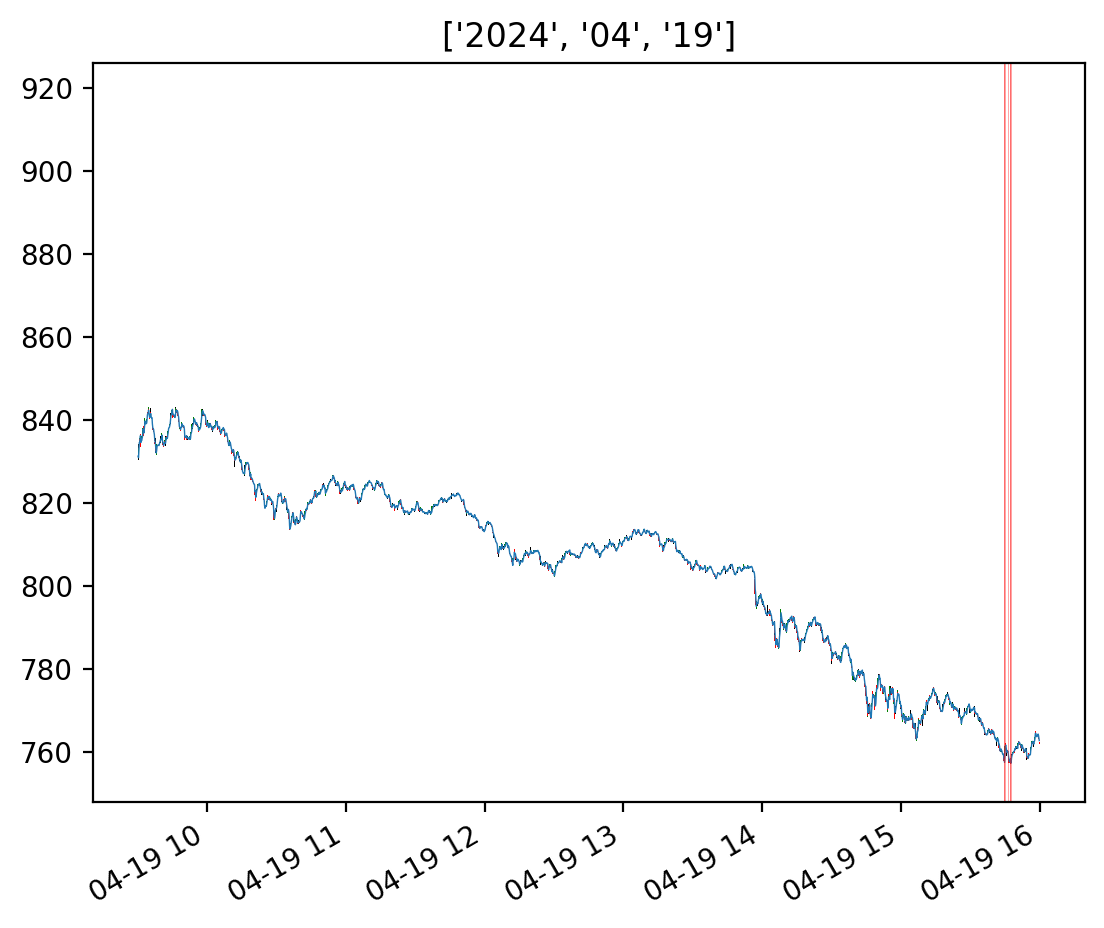

['2024', '04', '26']


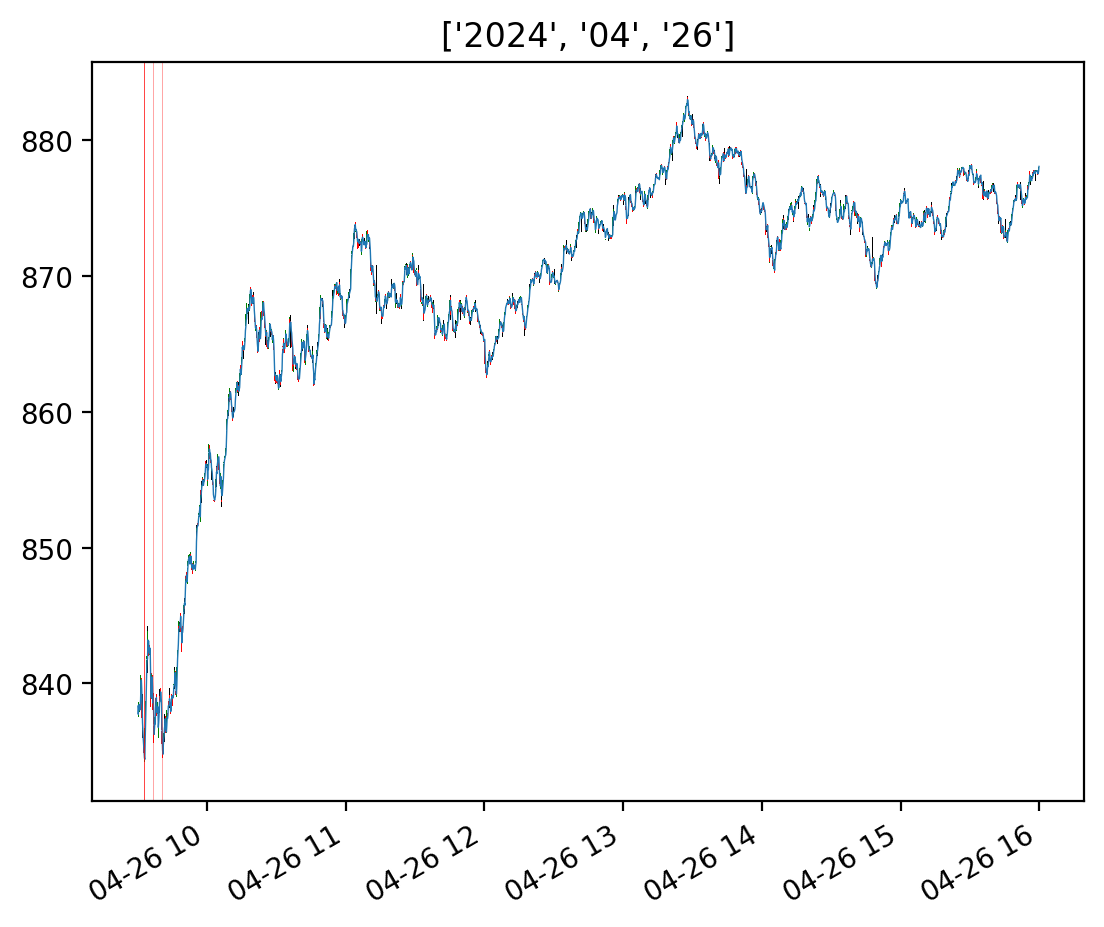

['2024', '05', '24']


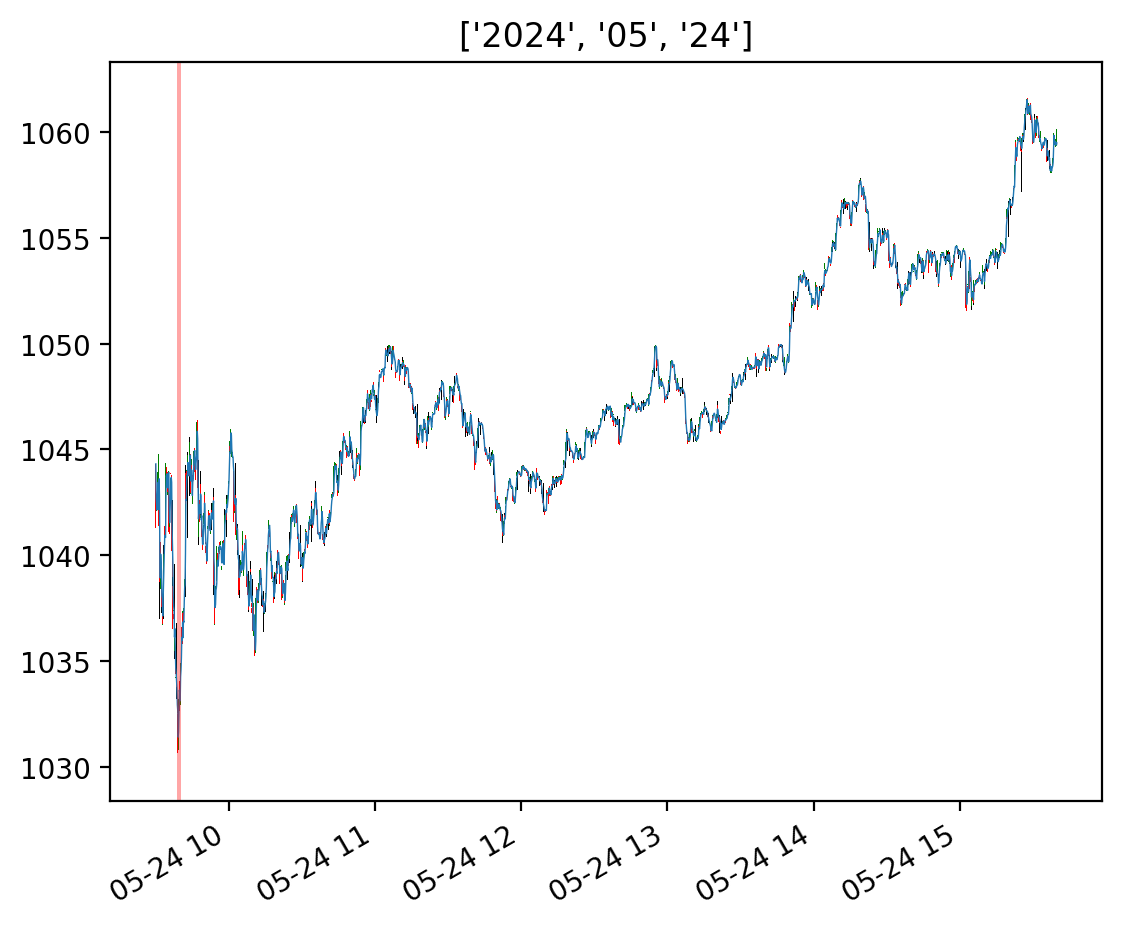

['2024', '05', '20']


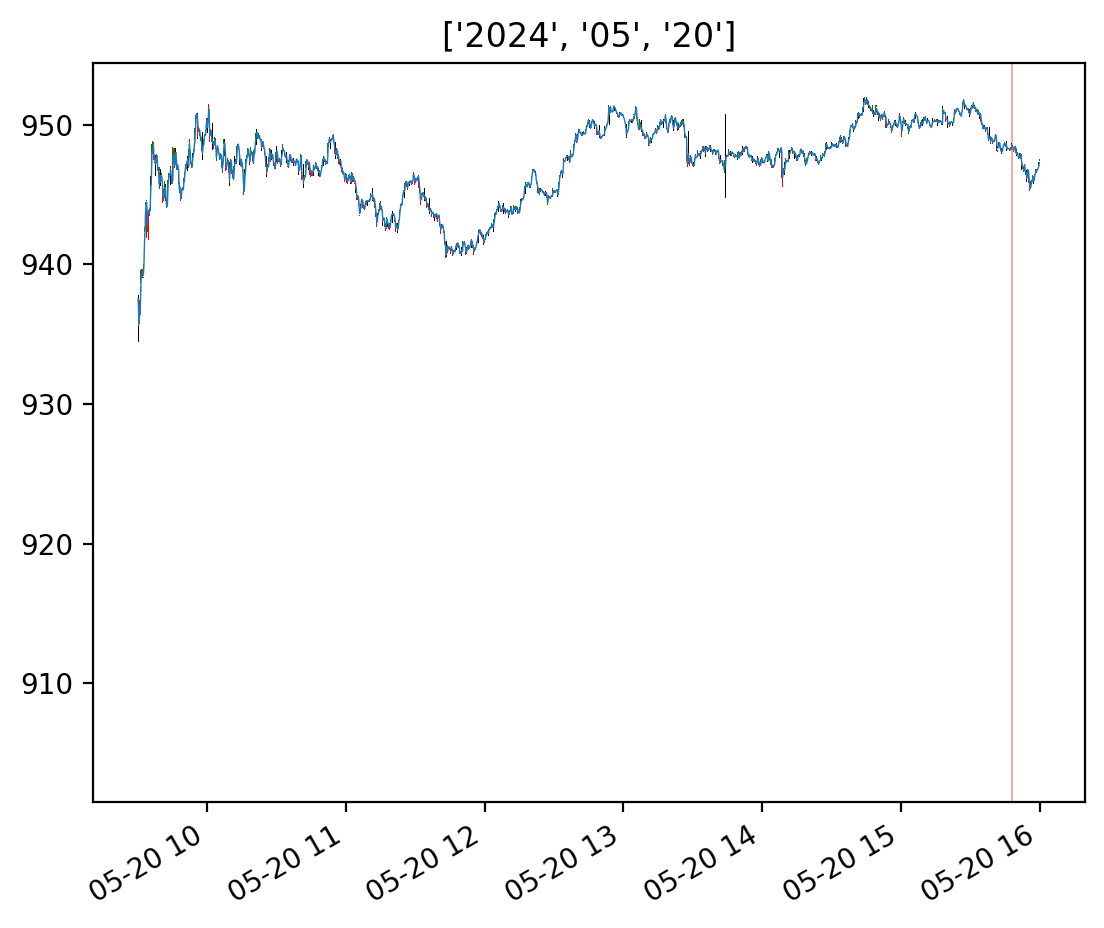

['2024', '05', '07']


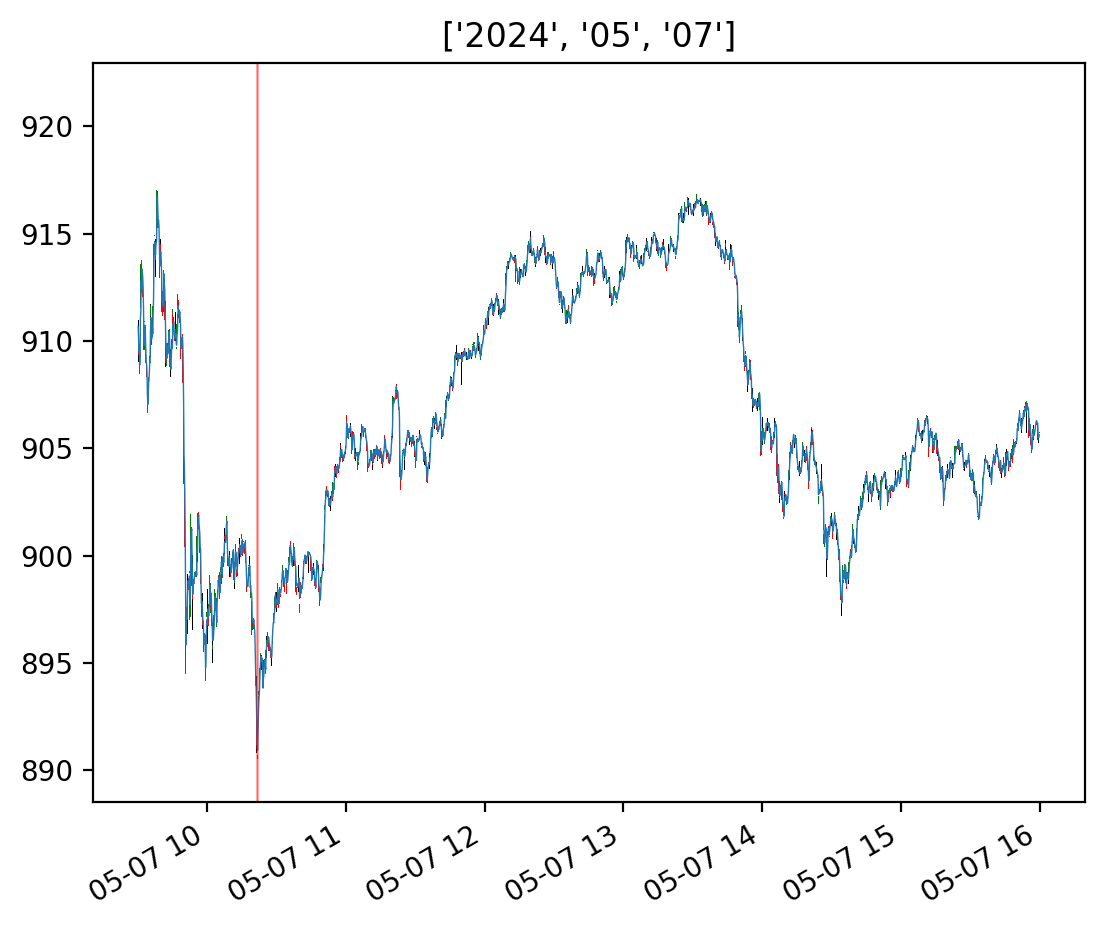

['2024', '04', '12']


KeyboardInterrupt: 

In [3]:
def get_entry_range(h, l, i):
    return (h.iloc[i]+l.iloc[i])/2

symbol = 'NVDA'
for f in glob.glob('../archive/processed/'+symbol+'/*'):
    d = (f.split('_')[-1].strip('.pkl')).split('-')
    print(d)
    df = sc.get_archive(symbol, tk.d(d[1],d[2],year=d[0]))
    h, l = tb.normalize_column(df.high), tb.normalize_column(df.low)
    #delta = df.diff()
    parts = []
    for i in range(len(df))[1:-1]:
        entry_range = get_entry_range(h, l, i)
        next_entry_range = get_entry_range(h, l, i+1)
        #print(round(entry_range,2), round(next_entry_range,2))
        if entry_range > next_entry_range * 2 or entry_range < next_entry_range * .5:
            parts.append(df.index[i])
    if parts:
        plt.figure(dpi=200)
        tb.candle_plot(df)
        plt.title(d)
        for index in parts:
            plt.axvline(index, color='red', lw=.25, alpha=.5)
        plt.show()

        
#sc.get_archive('NVDA',)